## **Extracting the zipfile**

- Use just once while opening

In [ ]:
import os
value = [i for i in os.listdir('drive/MyDrive') if i.endswith('.zip')]
import zipfile
z = zipfile.ZipFile('drive/MyDrive/anomaly_scoring_data.zip')
z.extractall('drive/MyDrive')

## APPROACH: 1

# **Main Code Starts**

##**Definition of the problem**:

- Given the value (in the form of time series prediction), predicted whether the behaviour (i.e the value of *value* column), is normal or there is some anomaly related to it.
- Now, there is one concerning thing that is, if the data can be categorised into normal or anomaly, based on some static methods, such as some statistics test, then maybe the algorithms are not needed, but that thing would be handled in the EDA part.

## **This part will include:**

1. **Exploratory Data Analysis**
2. **Testing 5 Models, which are suitable for this problems**

    a. KNN

    b. Random Forest (With Randomized Search)
    
    c. XGBoost
    
    d. Logistic Regression
    
    e. RNN
3. **Balancing the data and again testing the data**

  **NOTE: During the point 2&3, only the *value column* was used**
4. **Testing the model, while taking the *predicted column* into account**
5. **Giving the scores to the model**

### **1. Exploratory Data Analysis**

This will include:
* Exploring the value variable, and univariate analysis of the data, and some discussions about how would we, be handling the data
* Further, one important thing, is, if the problem can be solved with the help of some static methods, such as some statistics test, then maybe the algorithms are not needed, so that would be covered here.

In [ ]:
import os
import pathlib
data_path = pathlib.Path('drive/MyDrive/anomaly_scoring_data')    # For easily storing the path address of the parent directory of data files
csv_files = os.listdir('drive/MyDrive/anomaly_scoring_data')      # All the csv files

In [ ]:
import seaborn as sns
import matplotlib.style as style
sns.set(style='white')
sns.set(style = 'whitegrid',color_codes = True)
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
## Step 1: Read the file
import pandas as pd
df = pd.read_csv(data_path/csv_files[0])

In [ ]:
data  =pd.read_csv(data_path/csv_files[0])

In [ ]:
df.shape

(15830, 4)

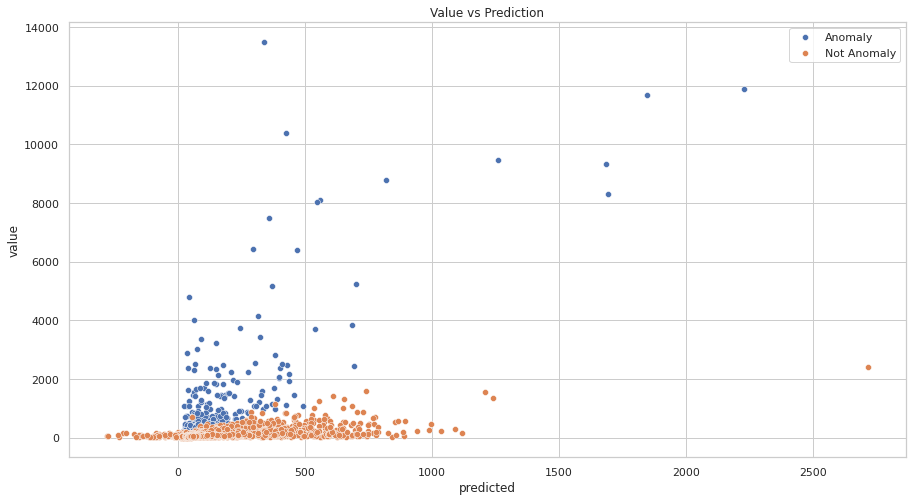

In [ ]:
plt.figure(figsize=(15,8))
sns.scatterplot(x = df[df['is_anomaly']==True]['predicted'],y = df[df['is_anomaly']==True]['value'])
sns.scatterplot(x = df[df['is_anomaly']==False]['predicted'],y = df[df['is_anomaly']==False]['value'])
plt.legend(['Anomaly','Not Anomaly'])
plt.title("Value vs Prediction")
plt.show()

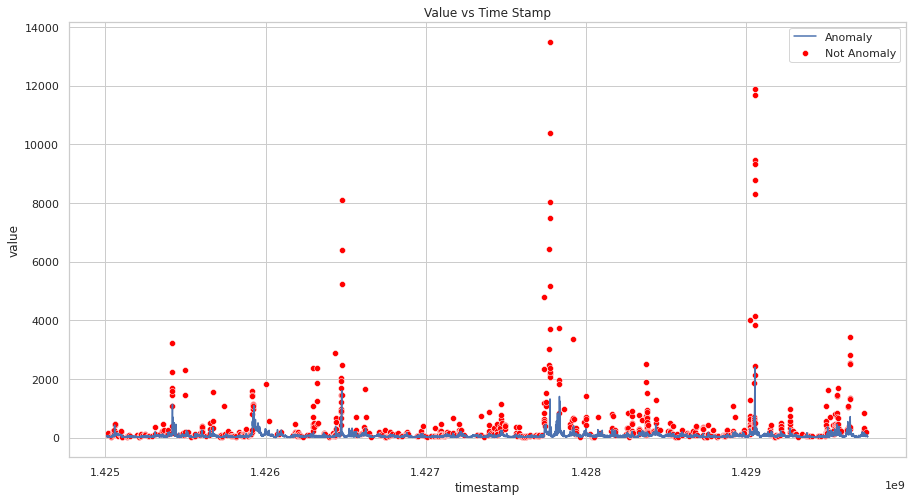

In [ ]:
plt.figure(figsize=(15,8))
sns.scatterplot(x = df[df['is_anomaly']==True]['timestamp'],y = df[df['is_anomaly']==True]['value'],color='red')
sns.lineplot(x = df[df['is_anomaly']==False]['timestamp'],y = df[df['is_anomaly']==False]['value'])
plt.legend(['Anomaly','Not Anomaly'])
plt.title("Value vs Time Stamp")
plt.show()

#### As per the guidelines in the Notion work book, it is mentioned that:

- **predicted [ float ] : is a real value prediction coming from a black box forecasting model for that timestamp.** This black box forecasting model is assumed to be aware of only the true data distribution of the time series, and cannot predict anomalies.

- **The candidate may choose to use or not use predicted values.**


#### So, we would be dropping the predicted value, (maybe it could be useful for the prediction of anomaly and ranking, but for now, we would be making it simple, by using timestamp and value)

In [ ]:
# Step 2: Remove the prediction column
df.drop(['predicted'],axis = 1,inplace=True)

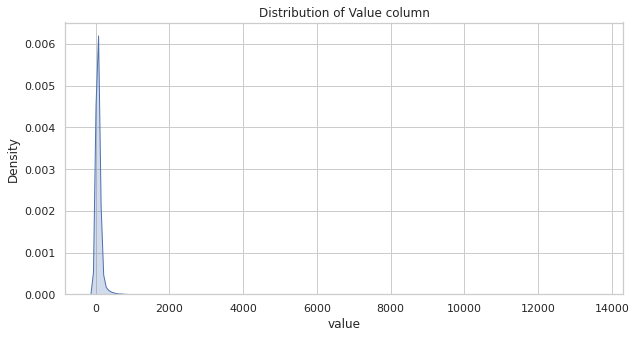

In [ ]:
# Step 3: Plot the density plot

plt.figure(figsize = (10,5))
sns.kdeplot(df['value'],shade=True)
plt.title("Distribution of Value column")
plt.show()

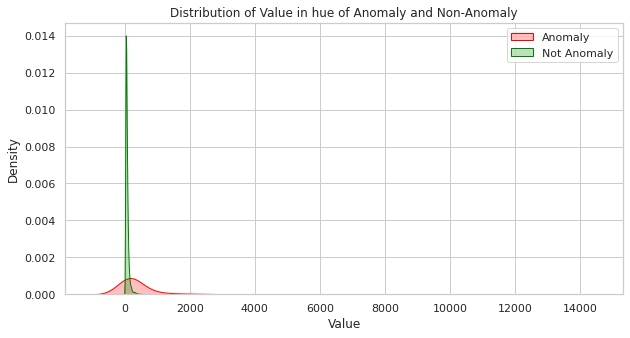

In [ ]:
# Step 4: Plot the distribution for each of the category

plt.figure(figsize=(10,5))
ax = sns.kdeplot(df['value'][df['is_anomaly']==True],color='red',shade=True)
ax = sns.kdeplot(df['value'][df['is_anomaly']==False],color='green',shade=True)
plt.legend(['Anomaly','Not Anomaly'])
plt.xlabel("Value")
plt.title("Distribution of Value in hue of Anomaly and Non-Anomaly")
plt.show()

In [ ]:
# Step 5: Calculating the deviation
df['deviation'] = df['value'] - df['value'].mean()

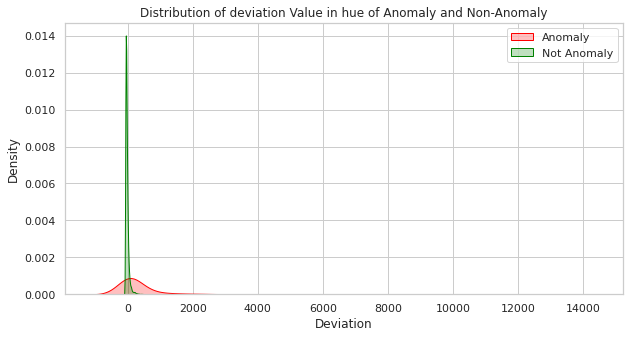

In [ ]:
# Step 6: Plot the deviation distribution for each of the category

plt.figure(figsize=(10,5))
ax = sns.kdeplot(df['deviation'][df['is_anomaly']==True],color='red',shade=True)
ax = sns.kdeplot(df['deviation'][df['is_anomaly']==False],color='green',shade=True)
plt.legend(['Anomaly','Not Anomaly'])
plt.xlabel("Deviation")
plt.title("Distribution of deviation Value in hue of Anomaly and Non-Anomaly")
plt.show()

In [ ]:
pip install chart_studio

In [ ]:
# Plotly
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
import colorlover as cl
from plotly.subplots import make_subplots

In [ ]:
# Figure layout
fig = make_subplots(rows=1, cols=1, insets=[{'cell': (1,1)}])
fig.update_layout(title="Boxplot of the Value column",font=dict(size=12,color="#7f7f7f"),
                 template = "ggplot2", title_font_size = 20, hovermode= 'closest')

# Figure data
fig.add_trace(go.Box(x = df['value'], y = df['is_anomaly'],boxpoints = 'all',jitter = 0.1, 
                     pointpos = -1.6, marker_color = 'rgb(210,105,30)', boxmean = True),
             row = 1, col = 1)

fig.update_traces(orientation='h')

#### We can see the outliers, in the diagram right. Now our main purpose was:

- Create a model, which predicts the anomaly.
- Now, I am thinking that, the points which can be definitely predicted to be outliers, should be removed from the ML model, and assign a high score.
- Or, maybe see if, a major population of the anomalous data point can be predicted with the help of some statistics test, then there is no need of ML Algorithm, let us see it.

### **Statistics Test:**
- I would use two most frequent methods:
1. Z-Score
2. IQR

In [ ]:
value = df['value'].mean() + 1.5*df['value'].std()
print(round(df[df['value']<value].shape[0]*100/df.shape[0],2))

# The below answer should the percentage of data points which are less than 1.5 STD, far from the mean

98.82


### Z - Score

The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.

In [ ]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df['value']))
df['zscore'] = z

In [ ]:
threshold = 3
df[df['zscore']>threshold]['is_anomaly'].value_counts()

True     89
False     9
Name: is_anomaly, dtype: int64

### Inter Quartile Range

- The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.

- In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles can be clearly seen on a box plot on the data.

- It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.

In [ ]:
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)
df[df['value']>Q1+1.5*IQR]['is_anomaly'].value_counts()

47.0


False    1923
True      528
Name: is_anomaly, dtype: int64

## Outliers:

- For the case of outlier, I think that Z-Score would work, since it outputs more accurately, the number of anomalies (may not be true, in all the data points)


## Inferences: (May not be true for all the csv files, but maybe we can go forward with it)

- The anomaly points are basically, present in a group and are just slightly deviated from each other.
- This means, for predicting if there is any anomaly or not we need to check the algorithm, with is based on the assumption, that points are more likely to behave similar to their neighbors
- Definitely, KNN and KMeans could work, and we would try some other alogrithm as well




## Approach: 

- My approach would be, take the `value` column, and then make a model out of it, which would predict if the value is anomaly or not, if it is an anomaly,we woud give the score taking into account **deviation from the mean** and **relative deviation** (deviation among the anomaly datapoints), maybe this should work.

- Hence, the role of ML algorithms would come into play, to predict if it is anomaly or not, and then scoring would be given by a formula which would be described later

**NOTE**: The main thing is, we need to develop the model, which can just detect correctly, the anomalous ones, accuracies can be achieved any how, means suppose out of 1000, there are 950 non- anomalous, and I predict every one has 0, I would achieve the accuracy of 95%, but that is not the case here.

SO, TO HANDLE IT WE WOULD BE USING PRECISION AND RECALL:

* Since, both precision and recall are important, from the business point of view, precision would be held more importance as compared to recall, because it is necessary that the algorithm alerts, to the concerned person, that there is some **un-normal behaviour observed**, definitely, it can not be accurate, but it can act as an alerting system, and that is what, we are developing, defintely, the recall should not be much less, means the model should not alert every now and then.

## **2. Testing 5 Models, which are suitable for this problems**

In [ ]:
outliers = df[df['zscore']>3].copy()
train_data = df[df['zscore']<=3].copy()

In [ ]:
## Model fitting
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
X = train_data['value'].values.reshape(-1,1)
y = train_data['is_anomaly'].astype(int).values

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,shuffle=True,random_state = 223)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.125,shuffle=True,random_state = 222)

## Algorithm - 1. Nearest Neigbors

In [ ]:
# 1. Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
accuracy = []
epoch = range(1,21,3)
for i in epoch:
    print("Current neighbor is:",i)
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train,y_train)
    val_score = accuracy_score(y_val, knn.predict(X_val))
    test_score= accuracy_score(y_test, knn.predict(X_test))
    print("The accuracy score on validation dataset is:", val_score)
    print("The accuracy score on test dataset is:", test_score)
    accuracy.append(test_score)

Current neighbor is: 1
The accuracy score on validation dataset is: 0.909148665819568
The accuracy score on test dataset is: 0.9221480775341595
Current neighbor is: 4
The accuracy score on validation dataset is: 0.9548919949174078
The accuracy score on test dataset is: 0.9555131871623769
Current neighbor is: 7
The accuracy score on validation dataset is: 0.9542566709021602
The accuracy score on test dataset is: 0.9536066094693358
Current neighbor is: 10
The accuracy score on validation dataset is: 0.9593392630241423
The accuracy score on test dataset is: 0.9561487130600572
Current neighbor is: 13
The accuracy score on validation dataset is: 0.957433290978399
The accuracy score on test dataset is: 0.9567842389577376
Current neighbor is: 16
The accuracy score on validation dataset is: 0.9567979669631512
The accuracy score on test dataset is: 0.9564664760088973
Current neighbor is: 19
The accuracy score on validation dataset is: 0.9561626429479034
The accuracy score on test dataset is: 0.

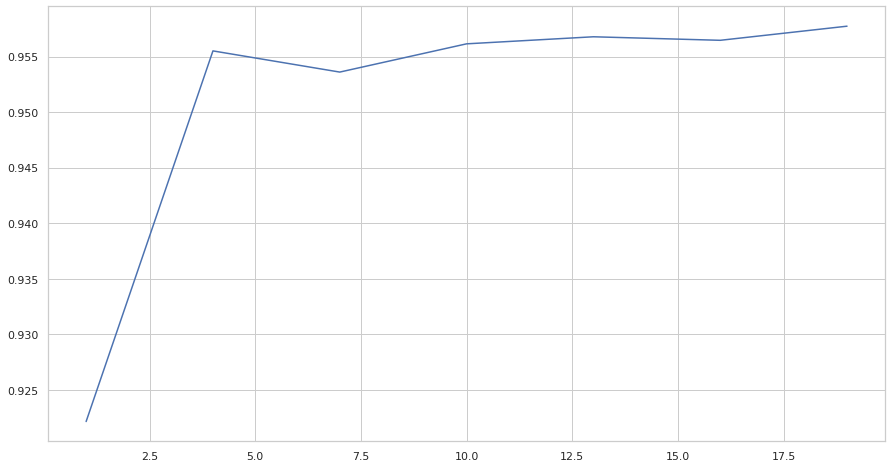

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,8))
sns.lineplot(x=epoch,y = accuracy)
plt.show()

In [ ]:
print("The classification report on test dataset is:")
print(classification_report(y_test, knn.predict(X_test)))
print("The accuracy score on test dataset is:", accuracy_score(y_test, knn.predict(X_test)))
print("The accuracy score on validation dataset is:", accuracy_score(y_val, knn.predict(X_val)))

The classification report on test dataset is:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3009
           1       0.60      0.11      0.18       138

    accuracy                           0.96      3147
   macro avg       0.78      0.55      0.58      3147
weighted avg       0.94      0.96      0.94      3147

The accuracy score on test dataset is: 0.957737527804258
The accuracy score on validation dataset is: 0.9561626429479034


Metrics:

We had already seen that, maybe K Nearest Neighbors are a good approximation to the problem, we got 

- Precision: 0.60
- Recall: 0.11

Maybe, precision is good, but stll we need to get reasonable recall as well, let us try other algorithms as well.

## Algorithm - 2. Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_val, y_val)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=10,
                                                    max_features='sqrt',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=4,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                 

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 200}

In [ ]:
import pickle
filename = 'rf_model.sav'
pickle.dump(rf_random,open(filename, 'wb'))

In [ ]:
print("The classification report for the test dataset is:")
print(classification_report(y_test, rf_random.predict(X_test)))
print("The accuracy score on test dataset is:", accuracy_score(y_test, rf_random.predict(X_test)))
print("The accuracy score on validation dataset is:", accuracy_score(y_val, rf_random.predict(X_val)))

The classification report for the test dataset is:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      3009
           1       0.42      0.16      0.23       138

    accuracy                           0.95      3147
   macro avg       0.69      0.57      0.60      3147
weighted avg       0.94      0.95      0.94      3147

The accuracy score on test dataset is: 0.9536066094693358
The accuracy score on validation dataset is: 0.9637865311308768


Metrics:

Using Random Forest, we got 

- Precision: 0.42
- Recall: 0.16

Maybe, precision lowered, and we need to get reasonable recall as well, let us try other algorithms.

## Algorithm - 3. XGBoost

In [ ]:
df_train = df

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df_train['value'].values.reshape(-1,1)
y = df_train['is_anomaly'].astype(int).values.reshape(-1,1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test.ravel(), y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.77%


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print("The classification report for the test dataset is:")
print(classification_report(y_test, model.predict(X_test)))
print("The accuracy score on test dataset is:", accuracy_score(y_test,model.predict(X_test)))
print("The accuracy score on validation dataset is:", accuracy_score(y_val, model.predict(X_val)))

The classification report for the test dataset is:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3009
           1       0.61      0.10      0.17       138

    accuracy                           0.96      3147
   macro avg       0.78      0.55      0.58      3147
weighted avg       0.94      0.96      0.94      3147

The accuracy score on test dataset is: 0.957737527804258
The accuracy score on validation dataset is: 0.9587039390088945


Metrics:

For XGBoost, we got the following things:

- Precision: 0.61
- Recall: 0.10

Maybe, precision is good, but stll we need to get reasonable recall as well, let us try other algorithms as well.

## Algorithm - 4. Logistic Regression

In [ ]:
df_train = df

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# X = df_train['value'].values.reshape(-1,1)
# y = df_train['is_anomaly'].astype(int).values.reshape(-1,1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = LogisticRegression()
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test.ravel(), y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.65%


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print("The classification report for the test dataset is:")
print(classification_report(y_test, model.predict(X_test)))
print("The accuracy score on test dataset is:", accuracy_score(y_test, model.predict(X_test)))
print("The accuracy score on validation dataset is:", accuracy_score(y_val, model.predict(X_val)))

The classification report for the test dataset is:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      3009
           1       0.51      0.13      0.21       138

    accuracy                           0.96      3147
   macro avg       0.74      0.56      0.59      3147
weighted avg       0.94      0.96      0.94      3147

The accuracy score on test dataset is: 0.9564664760088973
The accuracy score on validation dataset is: 0.9599745870393901


Metrics:

For Logistic Regression

- Precision: 0.51
- Recall: 0.13

Let us try RNN

## Algorithm 5 RNN

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(X)
data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 3000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train_s = data_n[0:-prediction_time-testdatacut].values
y_train_s = data_n[prediction_time:-testdatacut  ][0].values

# test data
x_test_s = data_n[0-testdatacut:-prediction_time].values
y_test_s = data_n[prediction_time-testdatacut:  ][0].values

In [ ]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train_s = unroll(x_train_s,unroll_length)
x_test_s  = unroll(x_test_s,unroll_length)
y_train = y_train[-x_train_s.shape[0]:]
y_test  = y_test[-x_test_s.shape[0]:]

# see the shape
print("x_train", x_train_s.shape)
print("y_train", y_train.shape)
print("x_test", x_test_s.shape)
print("y_test", y_test.shape)

x_train (12728, 50, 1)
y_train (11011,)
x_test (3000, 50, 1)
y_test (3000,)


In [ ]:
# specific libraries for RNN
# keras is a high layer build on Tensorflow layer to stay in high level/easy implementation
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys
import tensorflow as tf

In [ ]:
model = Sequential()
model.add(LSTM(50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.004805088043212891


In [ ]:
# Train the model

model.fit(
    x_train_s,
    y_train_s,
    batch_size=3028,
    epochs=10,
    validation_split=0.1)

Epoch 1/10
4/4 [==============================] - 72s 4s/step - loss: 0.7766 - val_loss: 0.0208
Epoch 2/10
4/4 [==============================] - 14s 3s/step - loss: 0.9117 - val_loss: 0.0165
Epoch 3/10
4/4 [==============================] - 14s 4s/step - loss: 0.5517 - val_loss: 0.0221
Epoch 4/10
4/4 [==============================] - 14s 4s/step - loss: 0.7252 - val_loss: 0.0166
Epoch 5/10
4/4 [==============================] - 14s 4s/step - loss: 0.6695 - val_loss: 0.0156
Epoch 6/10
4/4 [==============================] - 14s 3s/step - loss: 0.6360 - val_loss: 0.0154
Epoch 7/10
4/4 [==============================] - 14s 4s/step - loss: 0.8467 - val_loss: 0.0163
Epoch 8/10
4/4 [==============================] - 14s 4s/step - loss: 0.8186 - val_loss: 0.0144
Epoch 9/10
4/4 [==============================] - 14s 3s/step - loss: 0.5888 - val_loss: 0.0181
Epoch 10/10
4/4 [==============================] - 14s 3s/step - loss: 0.7195 - val_loss: 0.0149


In [ ]:
# create the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test_s)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

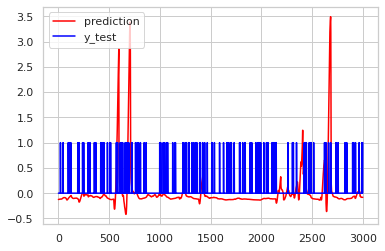

In [ ]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [ ]:
outliers_fraction = 0.08

In [ ]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
# # add the data to the main
df = complement.append(test, ignore_index='True')
print(df.value_counts())

0    15590
1      240
dtype: int64


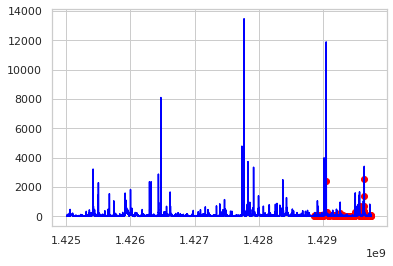

In [ ]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = data.iloc[df[df == 1].index]
b = data.iloc[df[df == 0].index]
ax.plot(b['timestamp'], b['value'], color='blue')
ax.scatter(a['timestamp'],a['value'], color='red')
#plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.show()

In [ ]:
print("The classification report for the dataset is:")
print(classification_report(data['is_anomaly'].astype(int).values, df.values))
print("The accuracy score on test dataset is:", accuracy_score(data['is_anomaly'].astype(int).values, df.values))
#print("The accuracy score on validation dataset is:", accuracy_score(y_val, model.predict(X_val)))

The classification report for the dataset is:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     15054
           1       0.07      0.02      0.03       776

    accuracy                           0.94     15830
   macro avg       0.51      0.50      0.50     15830
weighted avg       0.91      0.94      0.92     15830

The accuracy score on test dataset is: 0.9378395451674036


Metrics:

Using LSTMs, we got 

- Precision: 0.07
- Recall: 0.02

Nothing to say, just will not try it out, next time

## **3. Balancing the data and again testing the model**

In [ ]:
# Class count
count_class_0, count_class_1 = df_train.is_anomaly.value_counts()

# Divide by class
df_class_0 = df_train[df_train['is_anomaly'] == False]
df_class_1 = df_train[df_train['is_anomaly'] == True]


Random over-sampling:
True     15054
False    15054
Name: is_anomaly, dtype: int64


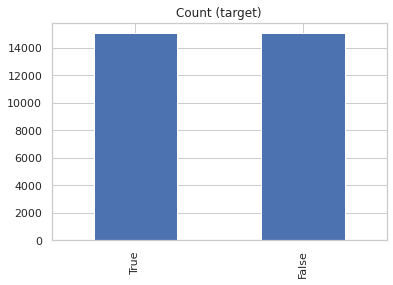

In [ ]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.is_anomaly.value_counts())

df_test_over.is_anomaly.value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
X_train_b,X_test_b,y_train_bal,y_test_b = train_test_split(df_test_over['value'].values.reshape(-1,1),df_test_over['is_anomaly'],test_size  =0.2,random_state = 22)
X_train_b,X_val_b,y_train_b,y_val_b = train_test_split(X_train,y_train,test_size = 0.125,random_state = 98)

## 1. Nearest Neigbors

In [ ]:
# 1. Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
accuracy = []
epoch = range(1,20)
for i in epoch:
    print("Current neighbor is:",i)
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_b,y_train_b)
    val_score = accuracy_score(y_val_b, knn.predict(X_val_b))
    test_score = accuracy_score(y_test_b, knn.predict(X_test_b))
    print("The accuracy score on validation dataset is:", round(val_score,4))
    print("The accuracy score on test dataset is:", round(test_score,4))
    print()
    accuracy.append(test_score)

Current neighbor is: 1
The accuracy score on validation dataset is: 0.9361
The accuracy score on test dataset is: 0.669

Current neighbor is: 2
The accuracy score on validation dataset is: 0.9586
The accuracy score on test dataset is: 0.5392

Current neighbor is: 3
The accuracy score on validation dataset is: 0.9572
The accuracy score on test dataset is: 0.6501

Current neighbor is: 4
The accuracy score on validation dataset is: 0.9579
The accuracy score on test dataset is: 0.6109

Current neighbor is: 5
The accuracy score on validation dataset is: 0.9542
The accuracy score on test dataset is: 0.6387

Current neighbor is: 6
The accuracy score on validation dataset is: 0.9564
The accuracy score on test dataset is: 0.6079

Current neighbor is: 7
The accuracy score on validation dataset is: 0.9608
The accuracy score on test dataset is: 0.6257

Current neighbor is: 8
The accuracy score on validation dataset is: 0.9601
The accuracy score on test dataset is: 0.6063

Current neighbor is: 9
Th

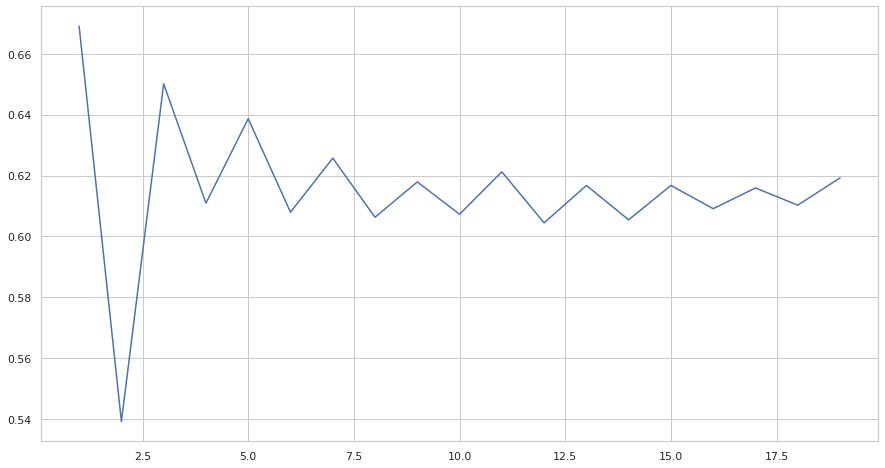

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,8))
sns.lineplot(epoch,accuracy)
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_b,y_train_b)
y_pred = knn.predict(X_test_b)

In [ ]:
print("The classification report for the test dataset is:")
print(classification_report(y_test_b, knn.predict(X_test_b)))
print("The accuracy score on test dataset is:", accuracy_score(y_test_b, model.predict(X_test_b)))
print("The accuracy score on validation dataset is:", accuracy_score(y_val_b, model.predict(X_val_b)))

The classification report for the test dataset is:
              precision    recall  f1-score   support

       False       0.58      0.99      0.74      3048
        True       0.98      0.27      0.43      2974

    accuracy                           0.64      6022
   macro avg       0.78      0.63      0.58      6022
weighted avg       0.78      0.64      0.58      6022

The accuracy score on test dataset is: 0.6195616074393889
The accuracy score on validation dataset is: 0.9629629629629629


Metrics:

We had already seen that, maybe K Nearest Neighbors are a good approximation to the problem, we got 

- Precision: 0.98
- Recall: 0.27

Maybe, precision is good, but stll we need to get reasonable recall as well, but this can be potential candidate, but still let us see other algorithms

## 2. Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_balanced = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_balanced.fit(X_val_b, y_val_b)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_random_balanced.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1600}

In [ ]:
rf  = RandomForestClassifier(bootstrap = True, max_depth= 10,
 max_features= 'sqrt',
 min_samples_leaf= 4,
 min_samples_split= 2,
 n_estimators= 1600)
rf.fit(X_train_b,y_train_b)

In [ ]:
import pickle
filename = 'rf_model_balanced.sav'
pickle.dump(rf,open(filename, 'wb'))

In [ ]:
print("The classification report is:")
print(classification_report(y_train_b, rf.predict(X_train_b)))
print("The accuracy score on validation dataset is:", accuracy_score(y_val_b, rf_random.predict(X_val_b)))
print("The accuracy score on test dataset is:", accuracy_score(y_test_b, rf.predict(X_test_b)))

The classification report is:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9213
           1       0.72      0.14      0.23       421

    accuracy                           0.96      9634
   macro avg       0.84      0.57      0.61      9634
weighted avg       0.95      0.96      0.95      9634

The accuracy score on validation dataset is: 0.9593318809005084
The accuracy score on test dataset is: 0.6110926602457655


Metrics:

Using Random Forest, we got

- Precision: 0.72
- Recall: 0.14

Maybe, precision is good, but stll we need to get reasonable recall as well, let us try other algorithms as well.

## Algorithm - 4. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# X = df_train['value'].values.reshape(-1,1)
# y = df_train['is_anomaly'].astype(int).values.reshape(-1,1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = LogisticRegression()
model.fit(X_train_b, y_train_b.ravel())
y_pred = model.predict(X_test_b)

accuracy = accuracy_score(y_test_b.ravel(), y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 61.76%


In [ ]:
y_pred = model.predict(X_test_b)

In [ ]:
print("The classification report for the test dataset is:")
print(classification_report(y_test_b, model.predict(X_test_b)))
print("The accuracy score on test dataset is:", accuracy_score(y_test_b, model.predict(X_test_b)))
print("The accuracy score on validation dataset is:", accuracy_score(y_val_b, model.predict(X_val_b)))

The classification report for the test dataset is:
              precision    recall  f1-score   support

       False       0.57      1.00      0.73      3048
        True       0.98      0.23      0.37      2974

    accuracy                           0.62      6022
   macro avg       0.78      0.61      0.55      6022
weighted avg       0.77      0.62      0.55      6022

The accuracy score on test dataset is: 0.6175689139820657
The accuracy score on validation dataset is: 0.9622367465504721


Metrics:

Using Logistic Regression

- Precision: 0.98
- Recall: 0.23

Maybe, precision is good, but stll we need to get reasonable recall as well, let us try other algorithms as well.

## **4. Testing the model, while taking the predicted column into account**

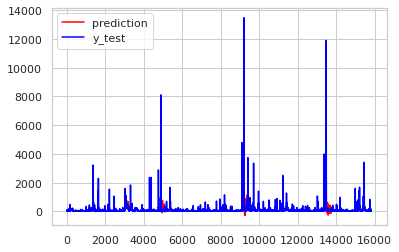

In [ ]:
df['is_anomaly'] = df['is_anomaly'].astype(int)
diff=[]
ratio=[]
p = df['predicted'].values.reshape(-1,1)
y = df['value'].copy().values.reshape(-1,1)
for u in range(len(y)):
    pr = p[u][0]
    ratio.append((y[u]/pr)-1)
    diff.append(abs(y[u]- pr)[0])
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
test.value_counts()

0    14247
1     1583
dtype: int64

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df['is_anomaly'],test))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     15054
           1       0.29      0.60      0.39       776

    accuracy                           0.91     15830
   macro avg       0.64      0.76      0.67     15830
weighted avg       0.94      0.91      0.92     15830



#### The above code describes that, just take the **predicted** and **value** column, and see if the difference between them, could be used to perdict the anomaly, however the precision is 0.29, and recall is high, but we need a good balance of both

## No Transformations

In [ ]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
X=df[['value','predicted']]
y = df['is_anomaly']

In [ ]:
from sklearn.model_selection import train_test_split
X_train_b,X_test_b,y_train_b,y_test_b = train_test_split(X,y,shuffle=True,random_state = 87)
X_train_b,X_val_b,y_train_b,y_val_b = train_test_split(X_train_b,y_train_b,shuffle=True,random_state = 87)
# 1. Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
accuracy = []
epoch = range(1,20)
for i in epoch:
    print("Current neighbor is:",i)
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_b,y_train_b)
    val_score = accuracy_score(y_val_b, knn.predict(X_val_b))
    test_score = accuracy_score(y_test_b, knn.predict(X_test_b))
    print("The accuracy score on validation dataset is:", round(val_score,4))
    print("The accuracy score on test dataset is:", round(test_score,4))
    print()
    accuracy.append(test_score)

Current neighbor is: 1
The accuracy score on validation dataset is: 0.9636
The accuracy score on test dataset is: 0.9613

Current neighbor is: 2
The accuracy score on validation dataset is: 0.968
The accuracy score on test dataset is: 0.9725

Current neighbor is: 3
The accuracy score on validation dataset is: 0.9693
The accuracy score on test dataset is: 0.9725

Current neighbor is: 4
The accuracy score on validation dataset is: 0.9697
The accuracy score on test dataset is: 0.9735

Current neighbor is: 5
The accuracy score on validation dataset is: 0.9697
The accuracy score on test dataset is: 0.9745

Current neighbor is: 6
The accuracy score on validation dataset is: 0.971
The accuracy score on test dataset is: 0.9742

Current neighbor is: 7
The accuracy score on validation dataset is: 0.9727
The accuracy score on test dataset is: 0.9755

Current neighbor is: 8
The accuracy score on validation dataset is: 0.9727
The accuracy score on test dataset is: 0.9745

Current neighbor is: 9
The

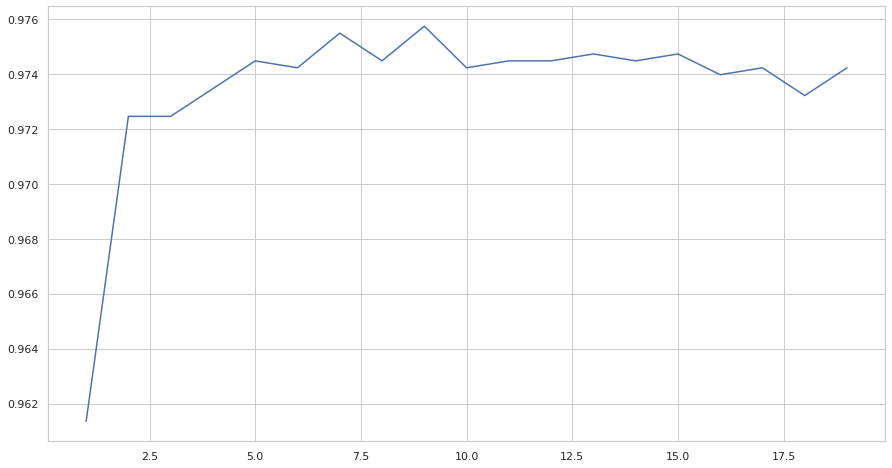

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,8))
sns.lineplot(epoch,accuracy)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(knn.predict(X_test_b),y_test_b))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3816
           1       0.61      0.80      0.69       142

    accuracy                           0.97      3958
   macro avg       0.80      0.89      0.84      3958
weighted avg       0.98      0.97      0.98      3958



Metrics:

We had already seen that, maybe K Nearest Neighbors are a good approximation to the problem, we got 

- Precision: 0.61
- Recall: 0.80

This time, we got good at both the things, that, it predicts 61% of the time, Anomaly, and 80% of the time it is correct. This shows that, predicted and value both have a good role to play for the prediction of value column

## Applying Transformations: Min Max Scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
s = MinMaxScaler()
X= s.fit_transform(df[['value','predicted']])
y = df['is_anomaly']

In [ ]:
from sklearn.model_selection import train_test_split
X_train_b,X_test_b,y_train_b,y_test_b = train_test_split(X,y,shuffle=True,random_state = 87)

In [ ]:
X_train_b,X_val_b,y_train_b,y_val_b = train_test_split(X_train_b,y_train_b,shuffle=True,random_state = 87)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# 1. Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
accuracy = []
epoch = range(1,20)
for i in epoch:
    print("Current neighbor is:",i)
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_b,y_train_b)
    val_score = accuracy_score(y_val_b, knn.predict(X_val_b))
    test_score = accuracy_score(y_test_b, knn.predict(X_test_b))
    print("The accuracy score on validation dataset is:", round(val_score,4))
    print("The accuracy score on test dataset is:", round(test_score,4))
    print()
    accuracy.append(test_score)

Current neighbor is: 1
The accuracy score on validation dataset is: 0.965
The accuracy score on test dataset is: 0.9631

Current neighbor is: 2
The accuracy score on validation dataset is: 0.9663
The accuracy score on test dataset is: 0.9722

Current neighbor is: 3
The accuracy score on validation dataset is: 0.969
The accuracy score on test dataset is: 0.9737

Current neighbor is: 4
The accuracy score on validation dataset is: 0.9697
The accuracy score on test dataset is: 0.9747

Current neighbor is: 5
The accuracy score on validation dataset is: 0.972
The accuracy score on test dataset is: 0.9752

Current neighbor is: 6
The accuracy score on validation dataset is: 0.9717
The accuracy score on test dataset is: 0.9765

Current neighbor is: 7
The accuracy score on validation dataset is: 0.9704
The accuracy score on test dataset is: 0.9778

Current neighbor is: 8
The accuracy score on validation dataset is: 0.969
The accuracy score on test dataset is: 0.9768

Current neighbor is: 9
The a

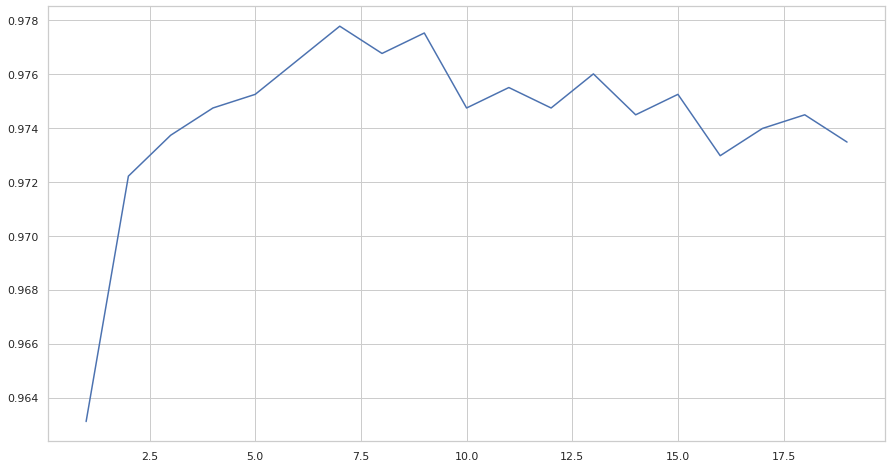

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,8))
sns.lineplot(epoch,accuracy)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(knn.predict(X_test_b),y_test_b))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3825
           1       0.57      0.81      0.67       133

    accuracy                           0.97      3958
   macro avg       0.78      0.90      0.83      3958
weighted avg       0.98      0.97      0.98      3958



Metrics:

We had already seen that, maybe K Nearest Neighbors are a good approximation to the problem, we got 

- Precision: 0.57
- Recall: 0.81

This time, we got good at both the things, that, it predicts 57% of the time, Anomaly, and 81% of the time it is correct. This shows that, predicted and value both have a good role to play for the prediction of value column

## Applying Transformations: Standard Scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
s = StandardScaler()
X= s.fit_transform(df[['value','predicted']])
y = df['is_anomaly']

In [ ]:
from sklearn.model_selection import train_test_split
X_train_b,X_test_b,y_train_b,y_test_b = train_test_split(X,y,shuffle=True,random_state = 87)

In [ ]:
X_train_b,X_val_b,y_train_b,y_val_b = train_test_split(X_train_b,y_train_b,shuffle=True,random_state = 87)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# 1. Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
accuracy = []
epoch = range(1,20)
for i in epoch:
    print("Current neighbor is:",i)
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_b,y_train_b)
    val_score = accuracy_score(y_val_b, knn.predict(X_val_b))
    test_score = accuracy_score(y_test_b, knn.predict(X_test_b))
    print("The accuracy score on validation dataset is:", round(val_score,4))
    print("The accuracy score on test dataset is:", round(test_score,4))
    print()
    accuracy.append(test_score)

Current neighbor is: 1
The accuracy score on validation dataset is: 0.9646
The accuracy score on test dataset is: 0.9649

Current neighbor is: 2
The accuracy score on validation dataset is: 0.9666
The accuracy score on test dataset is: 0.972

Current neighbor is: 3
The accuracy score on validation dataset is: 0.9697
The accuracy score on test dataset is: 0.9742

Current neighbor is: 4
The accuracy score on validation dataset is: 0.97
The accuracy score on test dataset is: 0.9735

Current neighbor is: 5
The accuracy score on validation dataset is: 0.9707
The accuracy score on test dataset is: 0.9745

Current neighbor is: 6
The accuracy score on validation dataset is: 0.9707
The accuracy score on test dataset is: 0.9752

Current neighbor is: 7
The accuracy score on validation dataset is: 0.9707
The accuracy score on test dataset is: 0.9778

Current neighbor is: 8
The accuracy score on validation dataset is: 0.971
The accuracy score on test dataset is: 0.9757

Current neighbor is: 9
The a

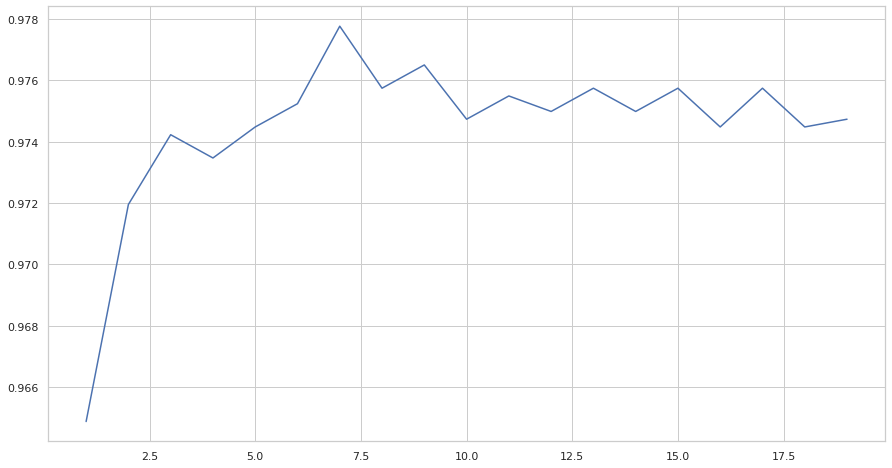

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,8))
sns.lineplot(epoch,accuracy)
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train_b,y_train_b)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(knn.predict(X_test_b),y_test_b))

              precision    recall  f1-score   support

       False       0.99      0.98      0.99      3810
        True       0.66      0.84      0.74       148

    accuracy                           0.98      3958
   macro avg       0.83      0.91      0.86      3958
weighted avg       0.98      0.98      0.98      3958



Metrics:

We had already seen that, maybe K Nearest Neighbors are a good approximation to the problem, we got 

- Precision: 0.66
- Recall: 0.84

This time, we got good at both the things, that, it predicts 66% of the time, Anomaly, and 84% of the time it is correct. This shows that, predicted and value both have a good role to play for the prediction of value column

#### So, we have finalized the solution for determining, whether the point is anomalous or non-anomalous

1. Algorithm used: KNN, n_neigbors = 7
2. Transformations: StandardScaler
3. Statistics test for predetermining the outliers: Z-Score



Now, the only thing left is giving scores to the anomalous point and then, plotting it.

# **Summary**
#### Creating a class for this whole process, so that it remains appropriate

In [ ]:
pip install chart_studio

In [ ]:
# Libraries

# Standard
import os
import pathlib
import seaborn as sns
import matplotlib.style as style
sns.set(style='white')
sns.set(style = 'whitegrid',color_codes = True)
import matplotlib.pyplot as plt
%matplotlib inline

# Manipulation
import pandas as pd
import numpy as np




# Plotly
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
import colorlover as cl
from plotly.subplots import make_subplots


# Sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [ ]:
class Solution:
  def __init__(self, path):
      self.df = pd.read_csv(path)
      self.model = KNeighborsClassifier(n_neighbors = 7)
      
    
  def plot_timegraph(self):
    # Anomalous and Non-Anomalous plot, with respect to the time stamp
    plt.figure(figsize=(15,8))
    sns.scatterplot(x = df[df['is_anomaly']==True]['timestamp'],y = df[df['is_anomaly']==True]['value'],color='red')
    sns.lineplot(x = df[df['is_anomaly']==False]['timestamp'],y = df[df['is_anomaly']==False]['value'])
    plt.legend(['Anomaly','Not Anomaly'])
    plt.title("Value vs Time Stamp")
    plt.show()

  def plot_box_plot(self):
    # Box Plot
    fig = make_subplots(rows=1, cols=1, insets=[{'cell': (1,1)}])
    fig.update_layout(title="Boxplot of the Value column",font=dict(size=12,color="#7f7f7f"),
                    template = "ggplot2", title_font_size = 20, hovermode= 'closest')

    # Figure data
    fig.add_trace(go.Box(x = self.df['value'], y = self.df['is_anomaly'],boxpoints = 'all',jitter = 0.1, 
                        pointpos = -1.6, marker_color = 'rgb(210,105,30)', boxmean = True),
                row = 1, col = 1)

    fig.update_traces(orientation='h')
    fig.show()
    
  def fit(self,X,y):
      # It is assumed that, no transformations are applied
      self.s = StandardScaler()
      X= self.s.fit_transform(X)
      self.model.fit(X,y)
      print("Model has been fitted successfully")
  
  def predict(self,X):
    print("Predicting.....")
    return self.model.predict(X)

  

In [ ]:
sol = Solution('drive/MyDrive/anomaly_scoring_data/0.csv')

In [ ]:
sol.plot_box_plot()